## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()



def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = 1.1* a + np.random.normal(mean, var, SIZE)
    c =  0.5* b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    f= b +  d + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
  
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 200
model_layers = [512, 256]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/f' + str(i))

print(models, model_names)

inputs = ['a', 'b']
target = ['c']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [51

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/f0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.1675 - mean_squared_error: 1.1675 - val_loss: 1.0509 - val_mean_squared_error: 1.0509

Epoch 00001: val_loss improved from inf to 1.05087, saving model to temp/f0
Epoch 2/20
20000/20000 [==============================] - 2s 97us/step - loss: 1.0499 - mean_squared_error: 1.0499 - val_loss: 1.0498 - val_mean_squared_error: 1.0498

Epoch 00002: val_loss improved from 1.05087 to 1.04978, saving model to temp/f0
Epoch 3/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0481 - mean_squared_error: 1.0481 - val_loss: 1.0397 - val_mean_squared_error: 1.0397

Epoch 00003: val_loss improved from 1.04978 to 1.03974, saving model to temp/f0
Epoch 4/20
20000/20000 [==============================] - 2s 98us/step - loss: 1.0483 - mean_squared_error: 1.0483 - val_loss: 1.0423 - val_mean_squared_error: 1.0423

Epoch 00004: val_loss did not im

20000/20000 [==============================] - 2s 102us/step - loss: 1.0452 - mean_squared_error: 1.0452 - val_loss: 1.0369 - val_mean_squared_error: 1.0369

Epoch 00005: val_loss improved from 1.03931 to 1.03685, saving model to temp/f4
Epoch 6/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0448 - mean_squared_error: 1.0448 - val_loss: 1.0457 - val_mean_squared_error: 1.0457

Epoch 00006: val_loss did not improve from 1.03685
Epoch 7/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0484 - mean_squared_error: 1.0484 - val_loss: 1.0373 - val_mean_squared_error: 1.0373

Epoch 00007: val_loss did not improve from 1.03685
Epoch 00007: early stopping
temp/f5
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 109us/step - loss: 1.2033 - mean_squared_error: 1.2033 - val_loss: 1.0609 - val_mean_squared_error: 1.0609

Epoch 00001: val_loss improved from inf to 1.06091, saving model to

20000/20000 [==============================] - 2s 85us/step - loss: 1.0395 - mean_squared_error: 1.0395 - val_loss: 1.0400 - val_mean_squared_error: 1.0400

Epoch 00007: val_loss did not improve from 1.03236
Epoch 8/20
20000/20000 [==============================] - 2s 88us/step - loss: 1.0366 - mean_squared_error: 1.0366 - val_loss: 1.0442 - val_mean_squared_error: 1.0442

Epoch 00008: val_loss did not improve from 1.03236
Epoch 00008: early stopping
temp/f10
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 93us/step - loss: 1.1953 - mean_squared_error: 1.1953 - val_loss: 1.0539 - val_mean_squared_error: 1.0539

Epoch 00001: val_loss improved from inf to 1.05388, saving model to temp/f10
Epoch 2/20
20000/20000 [==============================] - 2s 84us/step - loss: 1.0543 - mean_squared_error: 1.0543 - val_loss: 1.0538 - val_mean_squared_error: 1.0538

Epoch 00002: val_loss improved from 1.05388 to 1.05381, saving model to t


Epoch 00004: val_loss did not improve from 1.04132
Epoch 5/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0405 - mean_squared_error: 1.0405 - val_loss: 1.0506 - val_mean_squared_error: 1.0506

Epoch 00005: val_loss did not improve from 1.04132
Epoch 00005: early stopping
temp/f15
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.1887 - mean_squared_error: 1.1887 - val_loss: 1.0474 - val_mean_squared_error: 1.0474

Epoch 00001: val_loss improved from inf to 1.04735, saving model to temp/f15
Epoch 2/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0531 - mean_squared_error: 1.0531 - val_loss: 1.0426 - val_mean_squared_error: 1.0426

Epoch 00002: val_loss improved from 1.04735 to 1.04260, saving model to temp/f15
Epoch 3/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0526 - mean_squared_error: 1.0526 - val_loss: 1.0428 - val_mean

20000/20000 [==============================] - 2s 105us/step - loss: 1.1698 - mean_squared_error: 1.1698 - val_loss: 1.0525 - val_mean_squared_error: 1.0525

Epoch 00001: val_loss improved from inf to 1.05252, saving model to temp/f20
Epoch 2/20
20000/20000 [==============================] - 2s 95us/step - loss: 1.0480 - mean_squared_error: 1.0480 - val_loss: 1.0517 - val_mean_squared_error: 1.0517

Epoch 00002: val_loss improved from 1.05252 to 1.05172, saving model to temp/f20
Epoch 3/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0478 - mean_squared_error: 1.0478 - val_loss: 1.0412 - val_mean_squared_error: 1.0412

Epoch 00003: val_loss improved from 1.05172 to 1.04121, saving model to temp/f20
Epoch 4/20
20000/20000 [==============================] - 2s 99us/step - loss: 1.0420 - mean_squared_error: 1.0420 - val_loss: 1.0475 - val_mean_squared_error: 1.0475

Epoch 00004: val_loss did not improve from 1.04121
Epoch 5/20
20000/20000 [=======================


Epoch 00002: val_loss improved from 1.05034 to 1.04620, saving model to temp/f25
Epoch 3/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0529 - mean_squared_error: 1.0529 - val_loss: 1.0579 - val_mean_squared_error: 1.0579

Epoch 00003: val_loss did not improve from 1.04620
Epoch 4/20
20000/20000 [==============================] - 2s 101us/step - loss: 1.0421 - mean_squared_error: 1.0421 - val_loss: 1.0473 - val_mean_squared_error: 1.0473

Epoch 00004: val_loss did not improve from 1.04620
Epoch 00004: early stopping
temp/f26
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.1988 - mean_squared_error: 1.1988 - val_loss: 1.0530 - val_mean_squared_error: 1.0530

Epoch 00001: val_loss improved from inf to 1.05296, saving model to temp/f26
Epoch 2/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0514 - mean_squared_error: 1.0514 - val_loss: 1.0500 - val_mean

20000/20000 [==============================] - 2s 100us/step - loss: 1.0494 - mean_squared_error: 1.0494 - val_loss: 1.0388 - val_mean_squared_error: 1.0388

Epoch 00003: val_loss improved from 1.04670 to 1.03875, saving model to temp/f31
Epoch 4/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0431 - mean_squared_error: 1.0431 - val_loss: 1.0488 - val_mean_squared_error: 1.0488

Epoch 00004: val_loss did not improve from 1.03875
Epoch 5/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0468 - mean_squared_error: 1.0468 - val_loss: 1.0452 - val_mean_squared_error: 1.0452

Epoch 00005: val_loss did not improve from 1.03875
Epoch 00005: early stopping
temp/f32
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 108us/step - loss: 1.1942 - mean_squared_error: 1.1942 - val_loss: 1.0498 - val_mean_squared_error: 1.0498

Epoch 00001: val_loss improved from inf to 1.04976, saving model 


Epoch 00005: val_loss did not improve from 1.03872
Epoch 6/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0418 - mean_squared_error: 1.0418 - val_loss: 1.0409 - val_mean_squared_error: 1.0409

Epoch 00006: val_loss did not improve from 1.03872
Epoch 00006: early stopping
temp/f37
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.1888 - mean_squared_error: 1.1888 - val_loss: 1.0525 - val_mean_squared_error: 1.0525

Epoch 00001: val_loss improved from inf to 1.05253, saving model to temp/f37
Epoch 2/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0550 - mean_squared_error: 1.0550 - val_loss: 1.0500 - val_mean_squared_error: 1.0500

Epoch 00002: val_loss improved from 1.05253 to 1.04999, saving model to temp/f37
Epoch 3/20
20000/20000 [==============================] - 2s 91us/step - loss: 1.0533 - mean_squared_error: 1.0533 - val_loss: 1.0410 - val_mean_

20000/20000 [==============================] - 2s 99us/step - loss: 1.0461 - mean_squared_error: 1.0461 - val_loss: 1.0443 - val_mean_squared_error: 1.0443

Epoch 00003: val_loss improved from 1.04657 to 1.04432, saving model to temp/f41
Epoch 4/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0449 - mean_squared_error: 1.0449 - val_loss: 1.0510 - val_mean_squared_error: 1.0510

Epoch 00004: val_loss did not improve from 1.04432
Epoch 5/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0410 - mean_squared_error: 1.0410 - val_loss: 1.0376 - val_mean_squared_error: 1.0376

Epoch 00005: val_loss improved from 1.04432 to 1.03760, saving model to temp/f41
Epoch 6/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0408 - mean_squared_error: 1.0408 - val_loss: 1.0389 - val_mean_squared_error: 1.0389

Epoch 00006: val_loss did not improve from 1.03760
Epoch 7/20
20000/20000 [==============================] - 2s 101us/step 

20000/20000 [==============================] - 2s 103us/step - loss: 1.0451 - mean_squared_error: 1.0451 - val_loss: 1.0573 - val_mean_squared_error: 1.0573

Epoch 00003: val_loss did not improve from 1.04427
Epoch 4/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0445 - mean_squared_error: 1.0445 - val_loss: 1.0442 - val_mean_squared_error: 1.0442

Epoch 00004: val_loss improved from 1.04427 to 1.04425, saving model to temp/f46
Epoch 00004: early stopping
temp/f47
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 109us/step - loss: 1.1908 - mean_squared_error: 1.1908 - val_loss: 1.0585 - val_mean_squared_error: 1.0585

Epoch 00001: val_loss improved from inf to 1.05850, saving model to temp/f47
Epoch 2/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0554 - mean_squared_error: 1.0554 - val_loss: 1.0402 - val_mean_squared_error: 1.0402

Epoch 00002: val_loss improved from 1.0

20000/20000 [==============================] - 2s 103us/step - loss: 1.0452 - mean_squared_error: 1.0452 - val_loss: 1.0467 - val_mean_squared_error: 1.0467

Epoch 00003: val_loss improved from 1.05349 to 1.04668, saving model to temp/f52
Epoch 4/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0460 - mean_squared_error: 1.0460 - val_loss: 1.0412 - val_mean_squared_error: 1.0412

Epoch 00004: val_loss improved from 1.04668 to 1.04122, saving model to temp/f52
Epoch 5/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0377 - mean_squared_error: 1.0377 - val_loss: 1.0432 - val_mean_squared_error: 1.0432

Epoch 00005: val_loss did not improve from 1.04122
Epoch 6/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0436 - mean_squared_error: 1.0436 - val_loss: 1.0560 - val_mean_squared_error: 1.0560

Epoch 00006: val_loss did not improve from 1.04122
Epoch 00006: early stopping
temp/f53
Train on 20000 samples, validate o

20000/20000 [==============================] - 2s 102us/step - loss: 1.0451 - mean_squared_error: 1.0451 - val_loss: 1.0370 - val_mean_squared_error: 1.0370

Epoch 00006: val_loss improved from 1.03919 to 1.03702, saving model to temp/f57
Epoch 7/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0455 - mean_squared_error: 1.0455 - val_loss: 1.0363 - val_mean_squared_error: 1.0363

Epoch 00007: val_loss improved from 1.03702 to 1.03634, saving model to temp/f57
Epoch 8/20
20000/20000 [==============================] - 2s 101us/step - loss: 1.0381 - mean_squared_error: 1.0381 - val_loss: 1.0380 - val_mean_squared_error: 1.0380

Epoch 00008: val_loss did not improve from 1.03634
Epoch 9/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0393 - mean_squared_error: 1.0393 - val_loss: 1.0393 - val_mean_squared_error: 1.0393

Epoch 00009: val_loss did not improve from 1.03634
Epoch 00009: early stopping
temp/f58
Train on 20000 samples, validate o

20000/20000 [==============================] - 2s 98us/step - loss: 1.0398 - mean_squared_error: 1.0398 - val_loss: 1.0377 - val_mean_squared_error: 1.0377

Epoch 00007: val_loss did not improve from 1.03740
Epoch 00007: early stopping
temp/f62
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.1884 - mean_squared_error: 1.1884 - val_loss: 1.0508 - val_mean_squared_error: 1.0508

Epoch 00001: val_loss improved from inf to 1.05077, saving model to temp/f62
Epoch 2/20
20000/20000 [==============================] - 2s 101us/step - loss: 1.0531 - mean_squared_error: 1.0531 - val_loss: 1.0491 - val_mean_squared_error: 1.0491

Epoch 00002: val_loss improved from 1.05077 to 1.04914, saving model to temp/f62
Epoch 3/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0470 - mean_squared_error: 1.0470 - val_loss: 1.0425 - val_mean_squared_error: 1.0425

Epoch 00003: val_loss improved from 1.04

20000/20000 [==============================] - 2s 99us/step - loss: 1.0497 - mean_squared_error: 1.0497 - val_loss: 1.0446 - val_mean_squared_error: 1.0446

Epoch 00002: val_loss improved from 1.06360 to 1.04458, saving model to temp/f66
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0500 - mean_squared_error: 1.0500 - val_loss: 1.0436 - val_mean_squared_error: 1.0436

Epoch 00003: val_loss improved from 1.04458 to 1.04361, saving model to temp/f66
Epoch 4/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0479 - mean_squared_error: 1.0479 - val_loss: 1.0418 - val_mean_squared_error: 1.0418

Epoch 00004: val_loss improved from 1.04361 to 1.04184, saving model to temp/f66
Epoch 5/20
20000/20000 [==============================] - 2s 101us/step - loss: 1.0519 - mean_squared_error: 1.0519 - val_loss: 1.0323 - val_mean_squared_error: 1.0323

Epoch 00005: val_loss improved from 1.04184 to 1.03229, saving model to temp/f66
Epoch 6/20
2

20000/20000 [==============================] - 2s 103us/step - loss: 1.0532 - mean_squared_error: 1.0532 - val_loss: 1.0449 - val_mean_squared_error: 1.0449

Epoch 00004: val_loss did not improve from 1.04088
Epoch 00004: early stopping
temp/f72
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 110us/step - loss: 1.1831 - mean_squared_error: 1.1831 - val_loss: 1.0694 - val_mean_squared_error: 1.0694

Epoch 00001: val_loss improved from inf to 1.06935, saving model to temp/f72
Epoch 2/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0529 - mean_squared_error: 1.0529 - val_loss: 1.0492 - val_mean_squared_error: 1.0492

Epoch 00002: val_loss improved from 1.06935 to 1.04919, saving model to temp/f72
Epoch 3/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0529 - mean_squared_error: 1.0529 - val_loss: 1.0426 - val_mean_squared_error: 1.0426

Epoch 00003: val_loss improved from 1.0


Epoch 00003: val_loss improved from 1.04856 to 1.04488, saving model to temp/f76
Epoch 4/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0467 - mean_squared_error: 1.0467 - val_loss: 1.0428 - val_mean_squared_error: 1.0428

Epoch 00004: val_loss improved from 1.04488 to 1.04277, saving model to temp/f76
Epoch 5/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0413 - mean_squared_error: 1.0413 - val_loss: 1.0395 - val_mean_squared_error: 1.0395

Epoch 00005: val_loss improved from 1.04277 to 1.03953, saving model to temp/f76
Epoch 6/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0441 - mean_squared_error: 1.0441 - val_loss: 1.0448 - val_mean_squared_error: 1.0448

Epoch 00006: val_loss did not improve from 1.03953
Epoch 7/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0407 - mean_squared_error: 1.0407 - val_loss: 1.0427 - val_mean_squared_error: 1.0427

Epoch 00007: val_loss did not


Epoch 00004: val_loss improved from 1.04629 to 1.03869, saving model to temp/f81
Epoch 5/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0387 - mean_squared_error: 1.0387 - val_loss: 1.0478 - val_mean_squared_error: 1.0478

Epoch 00005: val_loss did not improve from 1.03869
Epoch 6/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0417 - mean_squared_error: 1.0417 - val_loss: 1.0360 - val_mean_squared_error: 1.0360

Epoch 00006: val_loss improved from 1.03869 to 1.03601, saving model to temp/f81
Epoch 7/20
20000/20000 [==============================] - 2s 101us/step - loss: 1.0411 - mean_squared_error: 1.0411 - val_loss: 1.0432 - val_mean_squared_error: 1.0432

Epoch 00007: val_loss did not improve from 1.03601
Epoch 8/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0419 - mean_squared_error: 1.0419 - val_loss: 1.0385 - val_mean_squared_error: 1.0385

Epoch 00008: val_loss did not improve from 1.03601
Epoch 00


Epoch 00005: val_loss did not improve from 1.04263
Epoch 00005: early stopping
temp/f86
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 110us/step - loss: 1.1786 - mean_squared_error: 1.1786 - val_loss: 1.0460 - val_mean_squared_error: 1.0460

Epoch 00001: val_loss improved from inf to 1.04601, saving model to temp/f86
Epoch 2/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0467 - mean_squared_error: 1.0467 - val_loss: 1.0437 - val_mean_squared_error: 1.0437

Epoch 00002: val_loss improved from 1.04601 to 1.04375, saving model to temp/f86
Epoch 3/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0480 - mean_squared_error: 1.0480 - val_loss: 1.0479 - val_mean_squared_error: 1.0479

Epoch 00003: val_loss did not improve from 1.04375
Epoch 4/20
20000/20000 [==============================] - 2s 101us/step - loss: 1.0495 - mean_squared_error: 1.0495 - val_loss: 1.0493 - val_mean

20000/20000 [==============================] - 2s 100us/step - loss: 1.0398 - mean_squared_error: 1.0398 - val_loss: 1.0386 - val_mean_squared_error: 1.0386

Epoch 00005: val_loss did not improve from 1.03847
Epoch 6/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0423 - mean_squared_error: 1.0423 - val_loss: 1.0465 - val_mean_squared_error: 1.0465

Epoch 00006: val_loss did not improve from 1.03847
Epoch 00006: early stopping
temp/f92
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.1876 - mean_squared_error: 1.1876 - val_loss: 1.0460 - val_mean_squared_error: 1.0460

Epoch 00001: val_loss improved from inf to 1.04605, saving model to temp/f92
Epoch 2/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0536 - mean_squared_error: 1.0536 - val_loss: 1.0532 - val_mean_squared_error: 1.0532

Epoch 00002: val_loss did not improve from 1.04605
Epoch 3/20
20000/2

20000/20000 [==============================] - 2s 102us/step - loss: 1.0386 - mean_squared_error: 1.0386 - val_loss: 1.0348 - val_mean_squared_error: 1.0348

Epoch 00007: val_loss improved from 1.04020 to 1.03482, saving model to temp/f97
Epoch 8/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0402 - mean_squared_error: 1.0402 - val_loss: 1.0346 - val_mean_squared_error: 1.0346

Epoch 00008: val_loss improved from 1.03482 to 1.03460, saving model to temp/f97
Epoch 9/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0425 - mean_squared_error: 1.0425 - val_loss: 1.0365 - val_mean_squared_error: 1.0365

Epoch 00009: val_loss did not improve from 1.03460
Epoch 10/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0402 - mean_squared_error: 1.0402 - val_loss: 1.0358 - val_mean_squared_error: 1.0358

Epoch 00010: val_loss did not improve from 1.03460
Epoch 00010: early stopping
temp/f98
Train on 20000 samples, validate 


Epoch 00004: val_loss did not improve from 1.04062
Epoch 5/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0485 - mean_squared_error: 1.0485 - val_loss: 1.0373 - val_mean_squared_error: 1.0373

Epoch 00005: val_loss improved from 1.04062 to 1.03730, saving model to temp/f102
Epoch 6/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0428 - mean_squared_error: 1.0428 - val_loss: 1.0336 - val_mean_squared_error: 1.0336

Epoch 00006: val_loss improved from 1.03730 to 1.03362, saving model to temp/f102
Epoch 7/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0429 - mean_squared_error: 1.0429 - val_loss: 1.0361 - val_mean_squared_error: 1.0361

Epoch 00007: val_loss did not improve from 1.03362
Epoch 8/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0434 - mean_squared_error: 1.0434 - val_loss: 1.0412 - val_mean_squared_error: 1.0412

Epoch 00008: val_loss did not improve from 1.03362
Epoch 

20000/20000 [==============================] - 2s 103us/step - loss: 1.0417 - mean_squared_error: 1.0417 - val_loss: 1.0327 - val_mean_squared_error: 1.0327

Epoch 00007: val_loss improved from 1.03618 to 1.03269, saving model to temp/f106
Epoch 8/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0369 - mean_squared_error: 1.0369 - val_loss: 1.0336 - val_mean_squared_error: 1.0336

Epoch 00008: val_loss did not improve from 1.03269
Epoch 9/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0383 - mean_squared_error: 1.0383 - val_loss: 1.0395 - val_mean_squared_error: 1.0395

Epoch 00009: val_loss did not improve from 1.03269
Epoch 00009: early stopping
temp/f107
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.1931 - mean_squared_error: 1.1931 - val_loss: 1.0622 - val_mean_squared_error: 1.0622

Epoch 00001: val_loss improved from inf to 1.06220, saving mode


Epoch 00008: val_loss did not improve from 1.03231
Epoch 00008: early stopping
temp/f112
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 110us/step - loss: 1.1898 - mean_squared_error: 1.1898 - val_loss: 1.0499 - val_mean_squared_error: 1.0499

Epoch 00001: val_loss improved from inf to 1.04986, saving model to temp/f112
Epoch 2/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0458 - mean_squared_error: 1.0458 - val_loss: 1.0567 - val_mean_squared_error: 1.0567

Epoch 00002: val_loss did not improve from 1.04986
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0490 - mean_squared_error: 1.0490 - val_loss: 1.0392 - val_mean_squared_error: 1.0392

Epoch 00003: val_loss improved from 1.04986 to 1.03917, saving model to temp/f112
Epoch 4/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0455 - mean_squared_error: 1.0455 - val_loss: 1.0403 - val_m

20000/20000 [==============================] - 2s 111us/step - loss: 1.1745 - mean_squared_error: 1.1745 - val_loss: 1.0678 - val_mean_squared_error: 1.0678

Epoch 00001: val_loss improved from inf to 1.06777, saving model to temp/f117
Epoch 2/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0532 - mean_squared_error: 1.0532 - val_loss: 1.0487 - val_mean_squared_error: 1.0487

Epoch 00002: val_loss improved from 1.06777 to 1.04868, saving model to temp/f117
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0551 - mean_squared_error: 1.0551 - val_loss: 1.0455 - val_mean_squared_error: 1.0455

Epoch 00003: val_loss improved from 1.04868 to 1.04548, saving model to temp/f117
Epoch 4/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0438 - mean_squared_error: 1.0438 - val_loss: 1.0497 - val_mean_squared_error: 1.0497

Epoch 00004: val_loss did not improve from 1.04548
Epoch 5/20
20000/20000 [==================


Epoch 00004: val_loss did not improve from 1.04534
Epoch 5/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0454 - mean_squared_error: 1.0454 - val_loss: 1.0539 - val_mean_squared_error: 1.0539

Epoch 00005: val_loss did not improve from 1.04534
Epoch 00005: early stopping
temp/f123
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.1757 - mean_squared_error: 1.1757 - val_loss: 1.0478 - val_mean_squared_error: 1.0478

Epoch 00001: val_loss improved from inf to 1.04783, saving model to temp/f123
Epoch 2/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0487 - mean_squared_error: 1.0487 - val_loss: 1.0433 - val_mean_squared_error: 1.0433

Epoch 00002: val_loss improved from 1.04783 to 1.04333, saving model to temp/f123
Epoch 3/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0508 - mean_squared_error: 1.0508 - val_loss: 1.0358 - val_m

20000/20000 [==============================] - 2s 105us/step - loss: 1.0455 - mean_squared_error: 1.0455 - val_loss: 1.0359 - val_mean_squared_error: 1.0359

Epoch 00006: val_loss improved from 1.04049 to 1.03588, saving model to temp/f127
Epoch 7/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0404 - mean_squared_error: 1.0404 - val_loss: 1.0350 - val_mean_squared_error: 1.0350

Epoch 00007: val_loss improved from 1.03588 to 1.03499, saving model to temp/f127
Epoch 8/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0405 - mean_squared_error: 1.0405 - val_loss: 1.0330 - val_mean_squared_error: 1.0330

Epoch 00008: val_loss improved from 1.03499 to 1.03299, saving model to temp/f127
Epoch 9/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0366 - mean_squared_error: 1.0366 - val_loss: 1.0367 - val_mean_squared_error: 1.0367

Epoch 00009: val_loss did not improve from 1.03299
Epoch 10/20
20000/20000 [=============

20000/20000 [==============================] - 2s 111us/step - loss: 1.1927 - mean_squared_error: 1.1927 - val_loss: 1.0603 - val_mean_squared_error: 1.0603

Epoch 00001: val_loss improved from inf to 1.06028, saving model to temp/f133
Epoch 2/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0529 - mean_squared_error: 1.0529 - val_loss: 1.0455 - val_mean_squared_error: 1.0455

Epoch 00002: val_loss improved from 1.06028 to 1.04551, saving model to temp/f133
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0464 - mean_squared_error: 1.0464 - val_loss: 1.0446 - val_mean_squared_error: 1.0446

Epoch 00003: val_loss improved from 1.04551 to 1.04465, saving model to temp/f133
Epoch 4/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0434 - mean_squared_error: 1.0434 - val_loss: 1.0543 - val_mean_squared_error: 1.0543

Epoch 00004: val_loss did not improve from 1.04465
Epoch 5/20
20000/20000 [==================

20000/20000 [==============================] - 2s 102us/step - loss: 1.0505 - mean_squared_error: 1.0505 - val_loss: 1.0489 - val_mean_squared_error: 1.0489

Epoch 00002: val_loss improved from 1.04985 to 1.04886, saving model to temp/f137
Epoch 3/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0480 - mean_squared_error: 1.0480 - val_loss: 1.0463 - val_mean_squared_error: 1.0463

Epoch 00003: val_loss improved from 1.04886 to 1.04632, saving model to temp/f137
Epoch 4/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0470 - mean_squared_error: 1.0470 - val_loss: 1.0502 - val_mean_squared_error: 1.0502

Epoch 00004: val_loss did not improve from 1.04632
Epoch 5/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0436 - mean_squared_error: 1.0436 - val_loss: 1.0397 - val_mean_squared_error: 1.0397

Epoch 00005: val_loss improved from 1.04632 to 1.03969, saving model to temp/f137
Epoch 6/20
20000/20000 [==============

20000/20000 [==============================] - 2s 105us/step - loss: 1.0367 - mean_squared_error: 1.0367 - val_loss: 1.0420 - val_mean_squared_error: 1.0420

Epoch 00008: val_loss did not improve from 1.04014
Epoch 00008: early stopping
temp/f141
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.1833 - mean_squared_error: 1.1833 - val_loss: 1.0500 - val_mean_squared_error: 1.0500

Epoch 00001: val_loss improved from inf to 1.05000, saving model to temp/f141
Epoch 2/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0548 - mean_squared_error: 1.0548 - val_loss: 1.0485 - val_mean_squared_error: 1.0485

Epoch 00002: val_loss improved from 1.05000 to 1.04848, saving model to temp/f141
Epoch 3/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0523 - mean_squared_error: 1.0523 - val_loss: 1.0421 - val_mean_squared_error: 1.0421

Epoch 00003: val_loss improved from 

20000/20000 [==============================] - 2s 104us/step - loss: 1.0546 - mean_squared_error: 1.0546 - val_loss: 1.0503 - val_mean_squared_error: 1.0503

Epoch 00002: val_loss improved from 1.07232 to 1.05035, saving model to temp/f146
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0490 - mean_squared_error: 1.0490 - val_loss: 1.0459 - val_mean_squared_error: 1.0459

Epoch 00003: val_loss improved from 1.05035 to 1.04586, saving model to temp/f146
Epoch 4/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0496 - mean_squared_error: 1.0496 - val_loss: 1.0403 - val_mean_squared_error: 1.0403

Epoch 00004: val_loss improved from 1.04586 to 1.04033, saving model to temp/f146
Epoch 5/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0476 - mean_squared_error: 1.0476 - val_loss: 1.0367 - val_mean_squared_error: 1.0367

Epoch 00005: val_loss improved from 1.04033 to 1.03675, saving model to temp/f146
Epoch 6


Epoch 00001: val_loss improved from inf to 1.05575, saving model to temp/f151
Epoch 2/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0475 - mean_squared_error: 1.0475 - val_loss: 1.0466 - val_mean_squared_error: 1.0466

Epoch 00002: val_loss improved from 1.05575 to 1.04661, saving model to temp/f151
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0441 - mean_squared_error: 1.0441 - val_loss: 1.0508 - val_mean_squared_error: 1.0508

Epoch 00003: val_loss did not improve from 1.04661
Epoch 4/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0433 - mean_squared_error: 1.0433 - val_loss: 1.0629 - val_mean_squared_error: 1.0629

Epoch 00004: val_loss did not improve from 1.04661
Epoch 00004: early stopping
temp/f152
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 110us/step - loss: 1.1928 - mean_squared_error: 1.1928 - val_loss: 1.0479 - val_m

20000/20000 [==============================] - 2s 102us/step - loss: 1.0493 - mean_squared_error: 1.0493 - val_loss: 1.0540 - val_mean_squared_error: 1.0540

Epoch 00003: val_loss did not improve from 1.04939
Epoch 4/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0453 - mean_squared_error: 1.0453 - val_loss: 1.0429 - val_mean_squared_error: 1.0429

Epoch 00004: val_loss improved from 1.04939 to 1.04293, saving model to temp/f156
Epoch 5/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0467 - mean_squared_error: 1.0467 - val_loss: 1.0498 - val_mean_squared_error: 1.0498

Epoch 00005: val_loss did not improve from 1.04293
Epoch 6/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0407 - mean_squared_error: 1.0407 - val_loss: 1.0373 - val_mean_squared_error: 1.0373

Epoch 00006: val_loss improved from 1.04293 to 1.03733, saving model to temp/f156
Epoch 7/20
20000/20000 [==============================] - 2s 103us/st


Epoch 00003: val_loss improved from 1.04896 to 1.04556, saving model to temp/f159
Epoch 4/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0476 - mean_squared_error: 1.0476 - val_loss: 1.0386 - val_mean_squared_error: 1.0386

Epoch 00004: val_loss improved from 1.04556 to 1.03860, saving model to temp/f159
Epoch 5/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0479 - mean_squared_error: 1.0479 - val_loss: 1.0378 - val_mean_squared_error: 1.0378

Epoch 00005: val_loss improved from 1.03860 to 1.03778, saving model to temp/f159
Epoch 6/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0426 - mean_squared_error: 1.0426 - val_loss: 1.0378 - val_mean_squared_error: 1.0378

Epoch 00006: val_loss did not improve from 1.03778
Epoch 7/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0419 - mean_squared_error: 1.0419 - val_loss: 1.0368 - val_mean_squared_error: 1.0368

Epoch 00007: val_loss impr

20000/20000 [==============================] - 2s 103us/step - loss: 1.0415 - mean_squared_error: 1.0415 - val_loss: 1.0393 - val_mean_squared_error: 1.0393

Epoch 00004: val_loss improved from 1.04468 to 1.03926, saving model to temp/f163
Epoch 5/20
20000/20000 [==============================] - 2s 95us/step - loss: 1.0440 - mean_squared_error: 1.0440 - val_loss: 1.0415 - val_mean_squared_error: 1.0415

Epoch 00005: val_loss did not improve from 1.03926
Epoch 6/20
20000/20000 [==============================] - 2s 97us/step - loss: 1.0429 - mean_squared_error: 1.0429 - val_loss: 1.0416 - val_mean_squared_error: 1.0416

Epoch 00006: val_loss did not improve from 1.03926
Epoch 00006: early stopping
temp/f164
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.2080 - mean_squared_error: 1.2080 - val_loss: 1.0508 - val_mean_squared_error: 1.0508

Epoch 00001: val_loss improved from inf to 1.05077, saving model 

20000/20000 [==============================] - 2s 104us/step - loss: 1.0481 - mean_squared_error: 1.0481 - val_loss: 1.0427 - val_mean_squared_error: 1.0427

Epoch 00002: val_loss improved from 1.05185 to 1.04268, saving model to temp/f168
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0466 - mean_squared_error: 1.0466 - val_loss: 1.0443 - val_mean_squared_error: 1.0443

Epoch 00003: val_loss did not improve from 1.04268
Epoch 4/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0434 - mean_squared_error: 1.0434 - val_loss: 1.0447 - val_mean_squared_error: 1.0447

Epoch 00004: val_loss did not improve from 1.04268
Epoch 00004: early stopping
temp/f169
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.1722 - mean_squared_error: 1.1722 - val_loss: 1.0532 - val_mean_squared_error: 1.0532

Epoch 00001: val_loss improved from inf to 1.05316, saving mode

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 108us/step - loss: 1.1869 - mean_squared_error: 1.1869 - val_loss: 1.0480 - val_mean_squared_error: 1.0480

Epoch 00001: val_loss improved from inf to 1.04796, saving model to temp/f174
Epoch 2/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0556 - mean_squared_error: 1.0556 - val_loss: 1.0497 - val_mean_squared_error: 1.0497

Epoch 00002: val_loss did not improve from 1.04796
Epoch 3/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0503 - mean_squared_error: 1.0503 - val_loss: 1.0504 - val_mean_squared_error: 1.0504

Epoch 00003: val_loss did not improve from 1.04796
Epoch 00003: early stopping
temp/f175
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.1938 - mean_squared_error: 1.1938 - val_loss: 1.0512 - val_mean_squared_error: 1.0512

Epoch 

20000/20000 [==============================] - 2s 103us/step - loss: 1.0464 - mean_squared_error: 1.0464 - val_loss: 1.0346 - val_mean_squared_error: 1.0346

Epoch 00004: val_loss improved from 1.04686 to 1.03457, saving model to temp/f179
Epoch 5/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0420 - mean_squared_error: 1.0420 - val_loss: 1.0430 - val_mean_squared_error: 1.0430

Epoch 00005: val_loss did not improve from 1.03457
Epoch 6/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0412 - mean_squared_error: 1.0412 - val_loss: 1.0373 - val_mean_squared_error: 1.0373

Epoch 00006: val_loss did not improve from 1.03457
Epoch 00006: early stopping
temp/f180
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.1960 - mean_squared_error: 1.1960 - val_loss: 1.0620 - val_mean_squared_error: 1.0620

Epoch 00001: val_loss improved from inf to 1.06205, saving mode

20000/20000 [==============================] - 2s 103us/step - loss: 1.0472 - mean_squared_error: 1.0472 - val_loss: 1.0433 - val_mean_squared_error: 1.0433

Epoch 00003: val_loss improved from 1.04650 to 1.04333, saving model to temp/f184
Epoch 4/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0449 - mean_squared_error: 1.0449 - val_loss: 1.0431 - val_mean_squared_error: 1.0431

Epoch 00004: val_loss improved from 1.04333 to 1.04310, saving model to temp/f184
Epoch 5/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0420 - mean_squared_error: 1.0420 - val_loss: 1.0442 - val_mean_squared_error: 1.0442

Epoch 00005: val_loss did not improve from 1.04310
Epoch 6/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0462 - mean_squared_error: 1.0462 - val_loss: 1.0345 - val_mean_squared_error: 1.0345

Epoch 00006: val_loss improved from 1.04310 to 1.03454, saving model to temp/f184
Epoch 7/20
20000/20000 [==============

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.1704 - mean_squared_error: 1.1704 - val_loss: 1.0492 - val_mean_squared_error: 1.0492

Epoch 00001: val_loss improved from inf to 1.04924, saving model to temp/f189
Epoch 2/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0504 - mean_squared_error: 1.0504 - val_loss: 1.0487 - val_mean_squared_error: 1.0487

Epoch 00002: val_loss improved from 1.04924 to 1.04870, saving model to temp/f189
Epoch 3/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0485 - mean_squared_error: 1.0485 - val_loss: 1.0510 - val_mean_squared_error: 1.0510

Epoch 00003: val_loss did not improve from 1.04870
Epoch 4/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0481 - mean_squared_error: 1.0481 - val_loss: 1.0401 - val_mean_squared_error: 1.0401

Epoch 00004: val_loss improved from 1.04870 to 1.04011, saving 


Epoch 00005: val_loss improved from 1.04002 to 1.03647, saving model to temp/f194
Epoch 6/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0478 - mean_squared_error: 1.0478 - val_loss: 1.0540 - val_mean_squared_error: 1.0540

Epoch 00006: val_loss did not improve from 1.03647
Epoch 7/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0427 - mean_squared_error: 1.0427 - val_loss: 1.0350 - val_mean_squared_error: 1.0350

Epoch 00007: val_loss improved from 1.03647 to 1.03501, saving model to temp/f194
Epoch 8/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0384 - mean_squared_error: 1.0384 - val_loss: 1.0383 - val_mean_squared_error: 1.0383

Epoch 00008: val_loss did not improve from 1.03501
Epoch 9/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0347 - mean_squared_error: 1.0347 - val_loss: 1.0322 - val_mean_squared_error: 1.0322

Epoch 00009: val_loss improved from 1.03501 to 1.03220, s


Epoch 00003: val_loss improved from 1.04746 to 1.04229, saving model to temp/f199
Epoch 4/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0471 - mean_squared_error: 1.0471 - val_loss: 1.0444 - val_mean_squared_error: 1.0444

Epoch 00004: val_loss did not improve from 1.04229
Epoch 5/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0447 - mean_squared_error: 1.0447 - val_loss: 1.0493 - val_mean_squared_error: 1.0493

Epoch 00005: val_loss did not improve from 1.04229
Epoch 00005: early stopping


In [4]:
nb_test = 2000
metrics_dicts = []
shap_dicts = []
shap_var = []
for m in models:
    metrics_dicts.append(defaultdict(list))
    shap_dicts.append(defaultdict(list))
    shap_var.append(defaultdict(list))
#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1,2,3]
variances = [1,2,3,4]



import shap
shap.initjs()
def get_shap(model, df, samples):
    x_train = df[inputs][:(samples * 2)]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    #shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

nshap = 500
base_df = gen_data()
def norm(a):
    return a / np.sum(a)
base_shap = norm(get_shap(model, df, nshap))
#shap_var.append(base_shap)


from sklearn.metrics import mean_absolute_error
# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print("<<<<<<<<", m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            print(model_name)
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))
            pred_shap = norm(get_shap(model, x_test2, nshap))
            shap_dicts[idx][str(m) + '_' + str(v)].append(mean_absolute_error(base_shap, pred_shap))
            shap_var[idx][str(m) + '_' + str(v)].append(pred_shap)
            print(mean_absolute_error(base_shap, pred_shap))
            print(pred_shap)


<<<<<<<< 0 1
temp/f0
0.013043776990835837
[0.41796823 0.58203177]
temp/f1
0.020930829212533336
[0.42585528 0.57414472]
temp/f2
0.014517297628460657
[0.41944175 0.58055825]
temp/f3
0.0060206242561191
[0.41094508 0.58905492]
temp/f4
0.012780536172567802
[0.41770499 0.58229501]
temp/f5
0.01889603599360265
[0.42382049 0.57617951]
temp/f6
0.009802544324097773
[0.414727 0.585273]
temp/f7
0.020254238995458085
[0.42517869 0.57482131]
temp/f8
0.023453736540742648
[0.42837819 0.57162181]
temp/f9
0.01433568549439998
[0.41926014 0.58073986]
temp/f10
0.009510788369109097
[0.41443524 0.58556476]
temp/f11
0.01782811685132696
[0.42275257 0.57724743]
temp/f12
0.01577601845399801
[0.42070047 0.57929953]
temp/f13
0.020634516096608296
[0.42555897 0.57444103]
temp/f14
0.0063684707587166045
[0.41129293 0.58870707]
temp/f15
0.013359575400503865
[0.41828403 0.58171597]
temp/f16
0.01824144235541142
[0.4231659 0.5768341]
temp/f17
0.025120311941352197
[0.43004477 0.56995523]
temp/f18
0.015142179002597178
[0.4200

0.013587965664118462
[0.41851242 0.58148758]
temp/f154
0.017157130121616515
[0.42208159 0.57791841]
temp/f155
0.023787732458522642
[0.42871219 0.57128781]
temp/f156
0.004251416278744979
[0.40917587 0.59082413]
temp/f157
0.014654655758545049
[0.41957911 0.58042089]
temp/f158
0.012203226687462182
[0.41712768 0.58287232]
temp/f159
0.011575249799348625
[0.41649971 0.58350029]
temp/f160
0.023335070267951535
[0.42825953 0.57174047]
temp/f161
0.012955158871162692
[0.41787961 0.58212039]
temp/f162
0.014640212634777605
[0.41956467 0.58043533]
temp/f163
0.007423626683908252
[0.41234808 0.58765192]
temp/f164
0.01657479183003477
[0.42149925 0.57850075]
temp/f165
0.025422202595278387
[0.43034666 0.56965334]
temp/f166
0.021012663208991533
[0.42593712 0.57406288]
temp/f167
0.007838573394673753
[0.41276303 0.58723697]
temp/f168
0.024789684647349736
[0.42971414 0.57028586]
temp/f169
0.010058474717159788
[0.41498293 0.58501707]
temp/f170
0.011426546301593399
[0.416351 0.583649]
temp/f171
0.0177468617581

0.0015807027990562272
[0.40334375 0.59665625]
temp/f105
0.002560846528448041
[0.40236361 0.59763639]
temp/f106
0.005701341014608563
[0.4106258 0.5893742]
temp/f107
0.008608806231650112
[0.41353326 0.58646674]
temp/f108
0.011043492335366695
[0.39388096 0.60611904]
temp/f109
0.008508384964923066
[0.41343284 0.58656716]
temp/f110
0.0008507959758554118
[0.40577525 0.59422475]
temp/f111
0.0035540593369749185
[0.40847851 0.59152149]
temp/f112
5.949521701023586e-05
[0.40486496 0.59513504]
temp/f113
0.0029295235894307714
[0.40785398 0.59214602]
temp/f114
0.008482943777758073
[0.39644151 0.60355849]
temp/f115
0.0029653057630520396
[0.40195915 0.59804085]
temp/f116
0.0007824344090107405
[0.40414202 0.59585798]
temp/f117
0.006301185631823442
[0.41122564 0.58877436]
temp/f118
0.0005084835284626665
[0.40543294 0.59456706]
temp/f119
0.017151335496510378
[0.38777312 0.61222688]
temp/f120
0.0027120506295677804
[0.40763651 0.59236349]
temp/f121
0.012050205814554321
[0.39287425 0.60712575]
temp/f122
0.0

0.015469147876150918
[0.4203936 0.5796064]
temp/f55
0.012433266208460497
[0.41735772 0.58264228]
temp/f56
0.01826075123764878
[0.42318521 0.57681479]
temp/f57
0.015910487579679333
[0.42083494 0.57916506]
temp/f58
0.024310322284561675
[0.42923478 0.57076522]
temp/f59
0.014026716610464757
[0.41895117 0.58104883]
temp/f60
0.01370861985344024
[0.41863308 0.58136692]
temp/f61
0.016295539185164493
[0.42121999 0.57878001]
temp/f62
0.017132966378524545
[0.42205742 0.57794258]
temp/f63
0.009889000910932977
[0.41481346 0.58518654]
temp/f64
0.015033652648515888
[0.41995811 0.58004189]
temp/f65
0.012768113119789676
[0.41769257 0.58230743]
temp/f66
0.011079344041765887
[0.4160038 0.5839962]
temp/f67
0.004032163073905609
[0.40895662 0.59104338]
temp/f68
0.010360409940394999
[0.41528487 0.58471513]
temp/f69
0.01263057279887217
[0.41755503 0.58244497]
temp/f70
0.006093319007447445
[0.41101777 0.58898223]
temp/f71
0.007240130487703722
[0.41216459 0.58783541]
temp/f72
0.01665739566092328
[0.42158185 0.5

0.0010389386607200235
[0.40596339 0.59403661]
temp/f7
0.013993361189984288
[0.41891782 0.58108218]
temp/f8
0.015038587659709723
[0.41996304 0.58003696]
temp/f9
0.006884600328051327
[0.41180906 0.58819094]
temp/f10
0.0020852676362234923
[0.40700972 0.59299028]
temp/f11
0.010308578003381197
[0.41523303 0.58476697]
temp/f12
0.007523378345802134
[0.41244783 0.58755217]
temp/f13
0.013188336722625704
[0.41811279 0.58188721]
temp/f14
0.0007051314410040366
[0.40421932 0.59578068]
temp/f15
0.0029527176039996217
[0.40787717 0.59212283]
temp/f16
0.009608795667137793
[0.41453325 0.58546675]
temp/f17
0.017425914118189667
[0.42235037 0.57764963]
temp/f18
0.010098504088738802
[0.41502296 0.58497704]
temp/f19
0.0027750083436743622
[0.40769946 0.59230054]
temp/f20
0.0007156867850107718
[0.40564014 0.59435986]
temp/f21
0.0037537566360055785
[0.40867821 0.59132179]
temp/f22
0.0029233034327899587
[0.40200115 0.59799885]
temp/f23
0.004693010528144748
[0.40961747 0.59038253]
temp/f24
0.011261796170654814
[0

0.006786761797700991
[0.41171122 0.58828878]
temp/f158
0.006563676510637412
[0.41148813 0.58851187]
temp/f159
0.0053431325868940616
[0.41026759 0.58973241]
temp/f160
0.01621852273149721
[0.42114298 0.57885702]
temp/f161
0.009019448773026184
[0.4139439 0.5860561]
temp/f162
0.005628709843200408
[0.41055317 0.58944683]
temp/f163
0.0008053580357393342
[0.40572981 0.59427019]
temp/f164
0.008446999558329005
[0.41337146 0.58662854]
temp/f165
0.018170818011943424
[0.42309527 0.57690473]
temp/f166
0.014765255809980699
[0.41968971 0.58031029]
temp/f167
0.0030792620967887707
[0.40800372 0.59199628]
temp/f168
0.01596258924364735
[0.42088704 0.57911296]
temp/f169
5.229251439636817e-05
[0.40487216 0.59512784]
temp/f170
0.0036004071550371775
[0.40852486 0.59147514]
temp/f171
0.008840910871632496
[0.41376537 0.58623463]
temp/f172
0.0033743705420489767
[0.40829883 0.59170117]
temp/f173
0.017009269944768007
[0.42193373 0.57806627]
temp/f174
0.010750907229021306
[0.41567536 0.58432464]
temp/f175
0.006999

0.022454193781958898
[0.42737865 0.57262135]
temp/f110
0.009595837468291124
[0.41452029 0.58547971]
temp/f111
0.014873195655375482
[0.41979765 0.58020235]
temp/f112
0.02116043878588833
[0.42608489 0.57391511]
temp/f113
0.020829297943975783
[0.42575375 0.57424625]
temp/f114
0.01057009871880435
[0.41549455 0.58450545]
temp/f115
0.010969331123432874
[0.41589379 0.58410621]
temp/f116
0.006560947295056019
[0.4114854 0.5885146]
temp/f117
0.02501799838487334
[0.42994245 0.57005755]
temp/f118
0.009610016881145184
[0.41453447 0.58546553]
temp/f119
0.0012754666656572822
[0.40364899 0.59635101]
temp/f120
0.01920697388028067
[0.42413143 0.57586857]
temp/f121
0.007326979089068986
[0.41225143 0.58774857]
temp/f122
0.025304690817572723
[0.43022915 0.56977085]
temp/f123
0.028400254271598813
[0.43332471 0.56667529]
temp/f124
0.015520187460050239
[0.42044464 0.57955536]
temp/f125
0.016961243914801444
[0.4218857 0.5781143]
temp/f126
0.004211439761274027
[0.40071302 0.59928698]
temp/f127
0.013520251655975

0.004739878735866648
[0.40018458 0.59981542]
temp/f61
0.006078477914926245
[0.39884598 0.60115402]
temp/f62
0.006467124926100659
[0.39845733 0.60154267]
temp/f63
0.012618958435407057
[0.3923055 0.6076945]
temp/f64
0.0044769387567528685
[0.40044752 0.59955248]
temp/f65
0.0005010862415743556
[0.40542554 0.59457446]
temp/f66
0.010019931846229763
[0.39490452 0.60509548]
temp/f67
0.010181147442389182
[0.39474331 0.60525669]
temp/f68
0.01585040812642874
[0.38907405 0.61092595]
temp/f69
0.005585159918967991
[0.3993393 0.6006607]
temp/f70
0.012939651031502103
[0.3919848 0.6080152]
temp/f71
0.009230587035940263
[0.39569387 0.60430613]
temp/f72
0.004006885446837721
[0.40091757 0.59908243]
temp/f73
0.010671871577841885
[0.39425258 0.60574742]
temp/f74
0.005840748377219596
[0.39908371 0.60091629]
temp/f75
0.005559441219238709
[0.4104839 0.5895161]
temp/f76
0.005361787834629983
[0.41028624 0.58971376]
temp/f77
0.007497360074642578
[0.3974271 0.6025729]
temp/f78
0.0067365810386976754
[0.39818787 0.6

0.0072252728776587005
[0.39769918 0.60230082]
temp/f11
0.003119176721806005
[0.40804363 0.59195637]
temp/f12
0.0033758008416145957
[0.40154865 0.59845135]
temp/f13
0.0007371768559103209
[0.40418728 0.59581272]
temp/f14
0.015533331550571017
[0.38939112 0.61060888]
temp/f15
0.007259058217264691
[0.3976654 0.6023346]
temp/f16
0.0018603565547240797
[0.4030641 0.5969359]
temp/f17
0.003444457671803597
[0.40836891 0.59163109]
temp/f18
0.0007743089828736449
[0.40569876 0.59430124]
temp/f19
0.0023868624400015526
[0.40253759 0.59746241]
temp/f20
0.008412017435715013
[0.39651244 0.60348756]
temp/f21
0.0054820536798404484
[0.3994424 0.6005576]
temp/f22
0.010135658419648252
[0.3947888 0.6052112]
temp/f23
0.005111007593335798
[0.39981345 0.60018655]
temp/f24
0.0017620353288043955
[0.40668649 0.59331351]
temp/f25
0.002294046569754127
[0.4072185 0.5927815]
temp/f26
0.002780692763985293
[0.40214376 0.59785624]
temp/f27
0.005847150036511178
[0.39907731 0.60092269]
temp/f28
0.015432151250606874
[0.389492

0.002028918724524098
[0.40289554 0.59710446]
temp/f162
0.004082599660210184
[0.40084186 0.59915814]
temp/f163
0.0037617401044047483
[0.40116272 0.59883728]
temp/f164
0.0012269478910719445
[0.40369751 0.59630249]
temp/f165
0.006537943406428132
[0.4114624 0.5885376]
temp/f166
0.0007700070865152009
[0.40415445 0.59584555]
temp/f167
0.007558085155823652
[0.39736637 0.60263363]
temp/f168
0.00413965207533018
[0.40906411 0.59093589]
temp/f169
0.0050938580929699995
[0.3998306 0.6001694]
temp/f170
0.0059270409288927906
[0.39899741 0.60100259]
temp/f171
0.0007858827331027052
[0.40413857 0.59586143]
temp/f172
0.0003327932430989
[0.40459166 0.59540834]
temp/f173
0.008254552475814747
[0.41317901 0.58682099]
temp/f174
0.0023372160154194743
[0.40258724 0.59741276]
temp/f175
0.005295311269639474
[0.39962914 0.60037086]
temp/f176
0.012371533610588237
[0.39255292 0.60744708]
temp/f177
0.0045897204936830305
[0.40033473 0.59966527]
temp/f178
0.007800771911714327
[0.41272523 0.58727477]
temp/f179
0.0041025

0.0028022287557772085
[0.40212223 0.59787777]
temp/f113
0.0004726986339715078
[0.40539715 0.59460285]
temp/f114
0.01121786209643616
[0.39370659 0.60629341]
temp/f115
0.006886583365993376
[0.39803787 0.60196213]
temp/f116
0.006657027861646264
[0.39826743 0.60173257]
temp/f117
0.00344350105347227
[0.40836796 0.59163204]
temp/f118
0.0038446716246084423
[0.40107978 0.59892022]
temp/f119
0.02046595643788543
[0.3844585 0.6155415]
temp/f120
0.0002550393060520295
[0.40466942 0.59533058]
temp/f121
0.013815284134451128
[0.39110917 0.60889083]
temp/f122
0.0032668040101423435
[0.40819126 0.59180874]
temp/f123
0.007936334820817653
[0.41286079 0.58713921]
temp/f124
0.0050504432609141114
[0.39987401 0.60012599]
temp/f125
0.0006340844139893498
[0.40429037 0.59570963]
temp/f126
0.016819062059366813
[0.38810539 0.61189461]
temp/f127
0.0007245599164808214
[0.4041999 0.5958001]
temp/f128
0.006164644891737736
[0.39875981 0.60124019]
temp/f129
0.005157518625003826
[0.39976694 0.60023306]
temp/f130
0.0052158

0.0042231120297318014
[0.40070134 0.59929866]
temp/f64
0.011477589381271414
[0.41640204 0.58359796]
temp/f65
0.022593836834768982
[0.42751829 0.57248171]
temp/f66
0.0058012590457925395
[0.41072571 0.58927429]
temp/f67
0.010226801378692751
[0.41515126 0.58484874]
temp/f68
0.005056668941085363
[0.39986779 0.60013221]
temp/f69
0.007690685886315052
[0.41261514 0.58738486]
temp/f70
0.006155864319024568
[0.41108032 0.58891968]
temp/f71
0.008102965240167265
[0.41302742 0.58697258]
temp/f72
0.00900223829232652
[0.41392669 0.58607331]
temp/f73
0.001686034430881278
[0.40323842 0.59676158]
temp/f74
0.012580419636548656
[0.41750488 0.58249512]
temp/f75
0.016238509475258484
[0.42116296 0.57883704]
temp/f76
0.013720241424522134
[0.4186447 0.5813553]
temp/f77
0.006731471423778113
[0.41165593 0.58834407]
temp/f78
0.006539072952850472
[0.39838538 0.60161462]
temp/f79
0.020092467644431566
[0.42501692 0.57498308]
temp/f80
0.010562569261322596
[0.39436189 0.60563811]
temp/f81
0.0077492261351861935
[0.4126

0.020664651259320793
[0.3842598 0.6157402]
temp/f15
0.008175489598905628
[0.39674897 0.60325103]
temp/f16
0.00261984783373026
[0.40230461 0.59769539]
temp/f17
0.0021217767435795787
[0.40280268 0.59719732]
temp/f18
0.00013936299422115384
[0.40478509 0.59521491]
temp/f19
0.0008790508058515445
[0.40580351 0.59419649]
temp/f20
0.008720455859625054
[0.396204 0.603796]
temp/f21
0.007423274973363425
[0.39750118 0.60249882]
temp/f22
0.006706712198258913
[0.39821774 0.60178226]
temp/f23
0.006330870072689815
[0.39859359 0.60140641]
temp/f24
0.0007307255518490263
[0.40565518 0.59434482]
temp/f25
0.0019923372491880142
[0.40691679 0.59308321]
temp/f26
0.0027069331941420305
[0.40221752 0.59778248]
temp/f27
0.00888261214646549
[0.39604184 0.60395816]
temp/f28
0.011097677842003939
[0.39382678 0.60617322]
temp/f29
0.010600782763238226
[0.41552524 0.58447476]
temp/f30
0.008383847268926742
[0.39654061 0.60345939]
temp/f31
0.0004918717482366997
[0.40443258 0.59556742]
temp/f32
0.017674589873438673
[0.3872

0.005687740484593362
[0.4106122 0.5893878]
temp/f166
0.007675850399670059
[0.39724861 0.60275139]
temp/f167
0.008375818431254511
[0.39654864 0.60345136]
temp/f168
0.002034414172333132
[0.40695887 0.59304113]
temp/f169
0.0017980306648566757
[0.40672249 0.59327751]
temp/f170
0.0075447807347374385
[0.39737967 0.60262033]
temp/f171
0.00041663854056808725
[0.40450782 0.59549218]
temp/f172
0.006061422206472267
[0.41098588 0.58901412]
temp/f173
0.008230452285953593
[0.41315491 0.58684509]
temp/f174
0.007016397139918584
[0.39790806 0.60209194]
temp/f175
0.010031889220819906
[0.39489257 0.60510743]
temp/f176
0.014148793644026936
[0.39077566 0.60922434]
temp/f177
0.0072722818807137435
[0.39765217 0.60234783]
temp/f178
0.007409095013266226
[0.41233355 0.58766645]
temp/f179
7.355498139333116e-05
[0.40499801 0.59500199]
temp/f180
4.700702048582306e-05
[0.40497146 0.59502854]
temp/f181
0.02086885712067335
[0.3840556 0.6159444]
temp/f182
0.0029623306866650434
[0.40196212 0.59803788]
temp/f183
0.00827

0.0013957662755287037
[0.40632022 0.59367978]
temp/f117
0.016665804304039522
[0.42159026 0.57840974]
temp/f118
0.004085777515798167
[0.40901023 0.59098977]
temp/f119
0.008848800013997488
[0.39607566 0.60392434]
temp/f120
0.011616880578653843
[0.41654134 0.58345866]
temp/f121
0.0006861713316947127
[0.40423828 0.59576172]
temp/f122
0.015578565256146204
[0.42050302 0.57949698]
temp/f123
0.021236792540940658
[0.42616125 0.57383875]
temp/f124
0.007925011965044415
[0.41284947 0.58715053]
temp/f125
0.009557997335600837
[0.41448245 0.58551755]
temp/f126
0.009499319756480995
[0.39542514 0.60457486]
temp/f127
0.007670422009364158
[0.41259488 0.58740512]
temp/f128
0.0069185491634044805
[0.411843 0.588157]
temp/f129
0.008679183948112956
[0.41360364 0.58639636]
temp/f130
0.007058280109191961
[0.41198274 0.58801726]
temp/f131
0.01341446032873947
[0.41833892 0.58166108]
temp/f132
0.01480744493170108
[0.4197319 0.5802681]
temp/f133
0.011318962834445695
[0.41624342 0.58375658]
temp/f134
0.0109987687355

0.006185937800349983
[0.39873852 0.60126148]
temp/f68
0.012076567005363442
[0.39284789 0.60715211]
temp/f69
0.00040786258490926874
[0.40533232 0.59466768]
temp/f70
0.008271121078799681
[0.39665333 0.60334667]
temp/f71
0.004558620843840427
[0.40036583 0.59963417]
temp/f72
0.0009073381114615142
[0.40583179 0.59416821]
temp/f73
0.006713622452313911
[0.39821083 0.60178917]
temp/f74
0.0013272152895941747
[0.40359724 0.59640276]
temp/f75
0.009654635744090923
[0.41457909 0.58542091]
temp/f76
0.009542339173298692
[0.41446679 0.58553321]
temp/f77
0.004259452408913483
[0.400665 0.599335]
temp/f78
0.0032840738532546876
[0.40164038 0.59835962]
temp/f79
0.006340627824286488
[0.41126508 0.58873492]
temp/f80
0.015307026931057233
[0.38961743 0.61038257]
temp/f81
0.00036188224561115034
[0.40456257 0.59543743]
temp/f82
0.014925691513272082
[0.41985015 0.58014985]
temp/f83
0.009763028590016792
[0.39516143 0.60483857]
temp/f84
0.013145021024042053
[0.39177943 0.60822057]
temp/f85
0.0015406718641668982
[0.

0.005430501462529935
[0.41035496 0.58964504]
temp/f18
0.01002596799257055
[0.41495042 0.58504958]
temp/f19
0.010573724127275613
[0.41549818 0.58450182]
temp/f20
0.0014785320879299457
[0.40640299 0.59359701]
temp/f21
0.003153617422003707
[0.40807807 0.59192193]
temp/f22
0.0042676510599980455
[0.40919211 0.59080789]
temp/f23
0.0011619117565392634
[0.40608637 0.59391363]
temp/f24
0.008769719024676353
[0.41369417 0.58630583]
temp/f25
0.007189086349905588
[0.41211354 0.58788646]
temp/f26
0.0017061034308952783
[0.40663056 0.59336944]
temp/f27
0.002476275034575842
[0.40244818 0.59755182]
temp/f28
0.0014774232380297125
[0.40344703 0.59655297]
temp/f29
0.024710060385966348
[0.42963452 0.57036548]
temp/f30
0.0010279778513274107
[0.40595243 0.59404757]
temp/f31
0.010803324374671908
[0.41572778 0.58427222]
temp/f32
0.005450446348805482
[0.39947401 0.60052599]
temp/f33
0.009573856703055772
[0.41449831 0.58550169]
temp/f34
0.006368536618166054
[0.41129299 0.58870701]
temp/f35
0.006207371157271102
[0

0.01166707717688667
[0.41659153 0.58340847]
temp/f169
0.01545168900777738
[0.42037614 0.57962386]
temp/f170
0.0029737613270097996
[0.40195069 0.59804931]
temp/f171
0.006555342915608164
[0.4114798 0.5885202]
temp/f172
0.016561423051909496
[0.42148588 0.57851412]
temp/f173
0.015482455589443722
[0.42040691 0.57959309]
temp/f174
0.0033706791624124877
[0.40155378 0.59844622]
temp/f175
0.007078408079533083
[0.39784605 0.60215395]
temp/f176
0.0035144986478896634
[0.40140996 0.59859004]
temp/f177
0.003797648764722661
[0.40112681 0.59887319]
temp/f178
0.01648887030695606
[0.42141333 0.57858667]
temp/f179
0.00919922081249644
[0.41412368 0.58587632]
temp/f180
0.009164968526558875
[0.41408942 0.58591058]
temp/f181
0.015141800743279366
[0.38978265 0.61021735]
temp/f182
0.006671541252740332
[0.411596 0.588404]
temp/f183
0.020898027254363488
[0.42582248 0.57417752]
temp/f184
0.0002779794470512409
[0.40520243 0.59479757]
temp/f185
0.0123500742793263
[0.41727453 0.58272547]
temp/f186
0.0343351160069376

0.009284027056157551
[0.39564043 0.60435957]
temp/f120
0.008003901038059591
[0.41292836 0.58707164]
temp/f121
0.0005468277108749975
[0.40437763 0.59562237]
temp/f122
0.012854477845092721
[0.41777893 0.58222107]
temp/f123
0.018041614517601112
[0.42296607 0.57703393]
temp/f124
0.005369283081084808
[0.41029374 0.58970626]
temp/f125
0.009770774894088813
[0.41469523 0.58530477]
temp/f126
0.01525532174967395
[0.38966913 0.61033087]
temp/f127
0.0028100934013023104
[0.40773455 0.59226545]
temp/f128
0.00503238102686715
[0.40995684 0.59004316]
temp/f129
0.0074135753372334134
[0.41233803 0.58766197]
temp/f130
0.003304221434517307
[0.40822868 0.59177132]
temp/f131
0.014262192356888442
[0.41918665 0.58081335]
temp/f132
0.015031781002029732
[0.41995624 0.58004376]
temp/f133
0.001612302829423068
[0.40653676 0.59346324]
temp/f134
0.0035539263639511043
[0.40847838 0.59152162]
temp/f135
0.008611576097598383
[0.41353603 0.58646397]
temp/f136
0.0004806016610636732
[0.40444385 0.59555615]
temp/f137
0.00370

0.0034100389476892368
[0.40833449 0.59166551]
temp/f70
0.0022917430630260693
[0.40263271 0.59736729]
temp/f71
0.0011559566695453771
[0.40608041 0.59391959]
temp/f72
0.004138576118096149
[0.40906303 0.59093697]
temp/f73
0.005609561992014261
[0.39931489 0.60068511]
temp/f74
0.004763366721870194
[0.40968782 0.59031218]
temp/f75
0.011496797222865174
[0.41642125 0.58357875]
temp/f76
0.009759565123805769
[0.41468402 0.58531598]
temp/f77
0.00039446055220745957
[0.40531892 0.59468108]
temp/f78
0.005971813584776997
[0.39895264 0.60104736]
temp/f79
0.014153943612456671
[0.4190784 0.5809216]
temp/f80
0.014790987318664517
[0.39013347 0.60986653]
temp/f81
0.002004831809620994
[0.40692929 0.59307071]
temp/f82
0.021612935474856765
[0.42653739 0.57346261]
temp/f83
0.007958709646771561
[0.39696575 0.60303425]
temp/f84
0.010992527225441417
[0.39393193 0.60606807]
temp/f85
0.003201592945394155
[0.40812605 0.59187395]
temp/f86
0.010440191949279504
[0.39448426 0.60551574]
temp/f87
0.0034301060140382034
[0.

0.003247691452860829
[0.40817215 0.59182785]
temp/f20
0.004719407970323053
[0.40020505 0.59979495]
temp/f21
0.004294864892496669
[0.40062959 0.59937041]
temp/f22
0.004614132484492189
[0.40031032 0.59968968]
temp/f23
0.002704457871435917
[0.40222 0.59778]
temp/f24
0.00434917802234977
[0.40927363 0.59072637]
temp/f25
0.004745160134489529
[0.40966962 0.59033038]
temp/f26
0.0005124181612199685
[0.40543687 0.59456313]
temp/f27
0.004678321261085278
[0.40024613 0.59975387]
temp/f28
0.009604381837351489
[0.39532007 0.60467993]
temp/f29
0.010697878528999477
[0.41562233 0.58437767]
temp/f30
0.006393543967115584
[0.39853091 0.60146909]
temp/f31
0.002206446257806083
[0.4071309 0.5928691]
temp/f32
0.01558878481826212
[0.38933567 0.61066433]
temp/f33
0.0015228648811229373
[0.40644732 0.59355268]
temp/f34
0.00120984755203013
[0.40371461 0.59628539]
temp/f35
0.010430875712734933
[0.39449358 0.60550642]
temp/f36
0.003965442052326212
[0.40095901 0.59904099]
temp/f37
0.00441318933395457
[0.40051127 0.599

0.0043226947295611495
[0.40060176 0.59939824]
temp/f171
0.0018155237499966892
[0.40673998 0.59326002]
temp/f172
0.00705781144138104
[0.41198227 0.58801773]
temp/f173
0.011638164956750713
[0.41656262 0.58343738]
temp/f174
0.003543298041237597
[0.40138116 0.59861884]
temp/f175
0.006518319874639689
[0.39840614 0.60159386]
temp/f176
0.010268369721783105
[0.39465609 0.60534391]
temp/f177
0.004173321067368924
[0.40075113 0.59924887]
temp/f178
0.01085628436486677
[0.41578074 0.58421926]
temp/f179
0.004860022463993752
[0.40978448 0.59021552]
temp/f180
0.0026915410922142557
[0.407616 0.592384]
temp/f181
0.01656768567204389
[0.38835677 0.61164323]
temp/f182
0.000943858091885158
[0.4039806 0.5960194]
temp/f183
0.01002389777351409
[0.41494835 0.58505165]
temp/f184
0.0034620323589917013
[0.40146242 0.59853758]
temp/f185
0.008450079353966355
[0.41337453 0.58662547]
temp/f186
0.025004294534566623
[0.42992875 0.57007125]
temp/f187
0.0024227025243425127
[0.40250175 0.59749825]
temp/f188
0.0060716048811

# USING BIC

In [5]:
#the number of times to sample
times = 1


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
full_conx = get_pairs(['a', 'b', 'c'])
forced_conx = set({('a','b'), ('a', 'c'), ('b', 'c')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9072.478005298286
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9014.028260770567
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9165.57268153405
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8986.208202797
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9051.532846878366
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8980.826748422332
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8993.213209229401
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9039.237304040524
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8984.502770606005
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8990.958074678707
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9004.97839136151
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9055.304775029264
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9048.04253882741
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9063.

['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9002.698109541472
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9012.046678097742
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8904.66867140064
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9003.269506275077
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9053.599623533159
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8956.658224366547
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9019.300258356281
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9026.017984944416
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9030.671722020772
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8993.336843447643
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -8950.415413567986
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9017.936682856141
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9004.743863810254
['a --> b', 'a --> c', 'b --> c']
-9476.790063991339 -9091.453409

In [6]:

MSE = []
SHAP = []
SHAP_VAR = []
VIO = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
        

    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))

    AUS.append(rectangular_approx)
    total_shap = []
    for k, v in shap_dicts[i].items():
        total_shap.append(np.mean(v))
    SHAP.append(np.sum(total_shap))

    var_l = []
    for k,v in shap_var[i].items():
        var_l.append(v)
    print(np.sum(np.var(var_l, axis = 0)))
    
    SHAP_VAR.append(np.sum(np.var(var_l, axis = 0)))


temp/f0
Area under surface (rectangular approx) =  177.8276045478242
Violations =  0.0
Average_violations =  -9072.478005298286
MSE =  1.0791851546287654
9.84411606156859e-05
temp/f1
Area under surface (rectangular approx) =  195.45213316849274
Violations =  0.0
Average_violations =  -9014.028260770567
MSE =  1.0909053318616844
8.701107190651545e-05
temp/f2
Area under surface (rectangular approx) =  175.6039990565023
Violations =  0.0
Average_violations =  -9165.57268153405
MSE =  1.0924888262760133
0.0001302017861935955
temp/f3
Area under surface (rectangular approx) =  190.51107338963422
Violations =  0.0
Average_violations =  -8986.208202797
MSE =  1.0878223278494086
9.410725903784869e-05
temp/f4
Area under surface (rectangular approx) =  177.06950134921578
Violations =  0.0
Average_violations =  -9051.532846878366
MSE =  1.0752350375435695
8.862696156202774e-05
temp/f5
Area under surface (rectangular approx) =  186.18316398855882
Violations =  0.0
Average_violations =  -8980.826748

Area under surface (rectangular approx) =  199.64949243448612
Violations =  0.0
Average_violations =  -8956.658224366547
MSE =  1.1015556001998639
8.631326471673745e-05
temp/f121
Area under surface (rectangular approx) =  184.9961515458088
Violations =  0.0
Average_violations =  -9019.300258356281
MSE =  1.0908032929238793
9.47225118277814e-05
temp/f122
Area under surface (rectangular approx) =  187.7861342290557
Violations =  0.0
Average_violations =  -9026.017984944416
MSE =  1.0953649673220798
0.00010165125206015182
temp/f123
Area under surface (rectangular approx) =  183.50617199833349
Violations =  0.0
Average_violations =  -9030.671722020772
MSE =  1.0829947233259045
7.486939604796857e-05
temp/f124
Area under surface (rectangular approx) =  188.64504198373305
Violations =  0.0
Average_violations =  -8993.336843447643
MSE =  1.0821911274296845
8.504245861279611e-05
temp/f125
Area under surface (rectangular approx) =  195.39444057797948
Violations =  0.0
Average_violations =  -8950

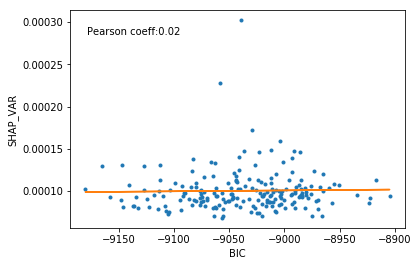

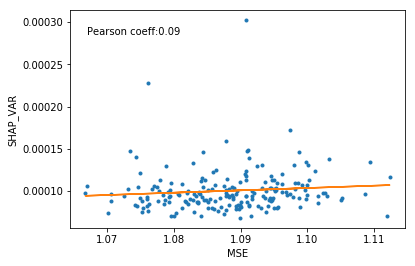

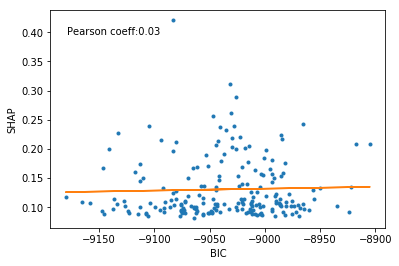

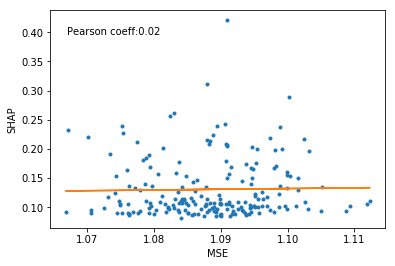

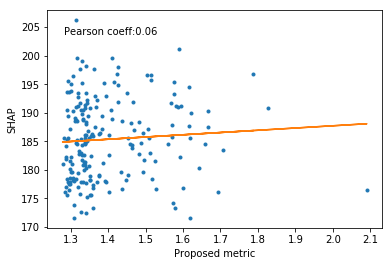

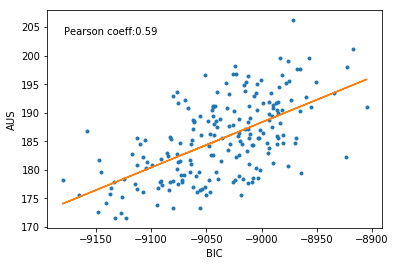

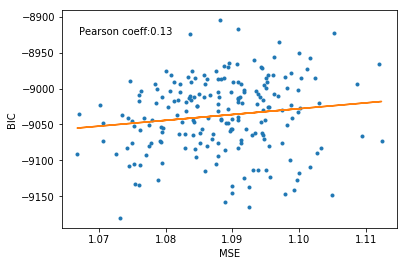

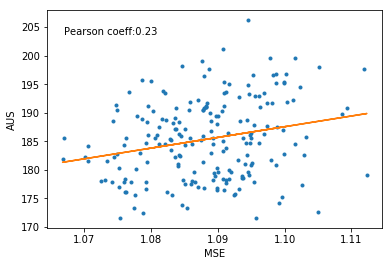

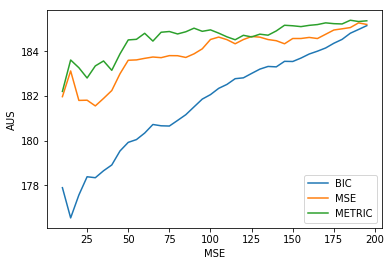

0.0688001997209994

In [7]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(MSE,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP, 1)
ax.plot(MSE,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = (SHAP/np.max(SHAP)) + np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(VIO,AUS, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,VIO, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,VIO)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,VIO, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("BIC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

In [10]:
def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + np.array(MSE)
n_low = 30

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(VIO,SHAP_VAR))]
print("SHAP VAR Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(MSE,SHAP_VAR))]
print("SHAP VAR Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(METRIC,SHAP_VAR))]
print("SHAP VAR Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP VAR Random = ", np.mean(SHAP_VAR[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(VIO,SHAP))]
print("SHAP Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(MSE,SHAP))]
print("SHAP Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP for _,SHAP in sorted(zip(METRIC,SHAP))]
print("SHAP Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP Random = ", np.mean(SHAP[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("AUS Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("AUS Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("AUS Best by MET = ", np.mean(sorted_aus[:n_low]))
print("AUS Random = ", np.mean(AUS[:n_low]))

SHAP VAR Best by BIC =  9.589905021527618e-05
SHAP VAR Best by MSE =  0.00010126573186570052
SHAP VAR Best by MET =  9.615199722876306e-05
SHAP VAR Random =  0.00010675757887831258
SHAP Best by BIC =  0.1265499539270751
SHAP Best by MSE =  0.13289802423457026
SHAP Best by MET =  0.12131619192959682
SHAP Random =  0.12378097477026023
AUS Best by BIC =  178.3436455073503
AUS Best by MSE =  181.55841116961957
AUS Best by MET =  178.5173622048918
AUS Random =  184.87389526637259


/home/tkyono/anaconda3/lib/python3.6/site-packages/shap/explainers/deep/deep_tf.py:138: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")


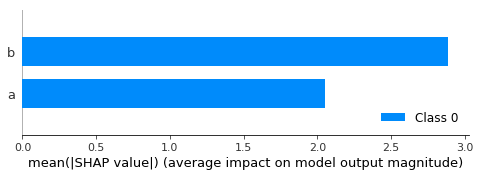

[2.0511480430364704, 2.883513928776927]

In [9]:
import shap
shap.initjs()
samples = 200
df = gen_data(mean = 2, var = 3)
x_train = df[inputs]
explainer_shap = shap.DeepExplainer(model=model, data=x_train)
shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
l = []
for f, feat in enumerate(inputs):
    tot = 0
    for i in shap_values[0]:
        for j in i:
            tot += np.abs(j[f])
    l.append(tot/samples)
l

